# Synthetic Data Generation: Libraries Comparison (SDV and Synthicity)

## Introduction
In this notebook, we will compare two of the most prominent open-source Python packages for synthetic data generation: SDV and Synthcity. The focus is on generating single-table synthetic data, meaning the output will be a single structured dataset.

### Datset Description
The dataset used in this experiment comes from publicly available data on UCI repository. It was collected by continuously monitoring a low-energy house in Belgium for 137 days, capturing both electrical energy consumption and environmental data. Energy consumption data was recorded every 10 minutes for various household appliances, while environmental data, such as temperature and humidity, was collected from multiple rooms through a wireless sensor network. Additionally, meteorological data from a nearby airport was merged into the dataset based on timestamps. The full dataset contains 19,735 records and 27 features, but in this study we will only use a subset of it for two main reasons. First, the dataset is too large to be processed efficiently with limited computational resources. Second, I want to evaluate how well the synthetic data generators can generate more data than what they are initially provided with, testing their ability to expand and generalize in different scenarios.

### Analysis Overview
The analysis is structured in two main parts. First, I will explore the SDV and Synthcity packages by using their built-in functions to generate and analyze synthetic data. Then, I will move to the evaluation phase, which is further divided into two parts. The first part will focus on statistical similarities between real and synthetic data, using both the evaluation functions provided by the packages and a custom statistical function that compares key statistical properties such as mean, median, standard deviation, variance, as well as Kolmogorov-Smirnov distance and Wasserstein distance. The second part will evaluate the difference in machine learning model performance when trained on real vs. synthetic data.

It is important to note that in this second part, I am not trying to optimize the models in any way. The goal is not to find the best-performing dataset for machine learning but rather to measure how closely the synthetic data preserves the predictive properties of the real data. A good synthetic data generator should produce datasets that lead to similar machine learning performance as the real data, not necessarily better.

### Goals
The primary goal of this study is to evaluate which synthetic data generator performs best in creating data that is statistically similar to the real dataset.
The study also aims to explore how synthetic and real data differ when used to train machine learning models. By applying multiple machine learning models to both real and synthetic datasets, I will compare their predictive performance using key evaluation metrics such as Mean Absolute Error (MAE), Mean Squared Error (MSE), and R² score. 
However, the goal is not to optimize these models but to assess how well the synthetic data preserves the predictive characteristics of the real dataset

Let's start!

First of all, let's import all the needed libraries.

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch 
from scipy.stats import ks_2samp, wasserstein_distance
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.single_table import TVAESynthesizer
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdv.evaluation.single_table import get_column_plot
from sdv.metadata import Metadata
from synthcity.plugins import Plugins

c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


Next, we import the dataset containing household energy consumption data.

In [3]:
# Importing the training dataset that we will use to create syntethic data
df = pd.read_csv("Datasets/energydata_complete.csv", nrows=1000) # Taking only the first 1000 rows for memory limitation

# Inspect data 
print(df.head())

              date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  1/11/2016 17:00          60      30  19.89  47.596667  19.2  44.790000   
1  1/11/2016 17:10          60      30  19.89  46.693333  19.2  44.722500   
2  1/11/2016 17:20          50      30  19.89  46.300000  19.2  44.626667   
3  1/11/2016 17:30          50      40  19.89  46.066667  19.2  44.590000   
4  1/11/2016 17:40          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9  T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53   6.60        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56   6.48        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50   6.37        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40   6.25        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40   6.13        733.9   

   RH_out  Windspeed  Visibility  Tdewpoint        rv1        rv2  
0    9

Inspecting the dataset and handling missing values to ensure data quality before proceeding with analysis.

In [4]:
# Missing values
miss_info = df.isnull().sum()

treshold = 0.5 * len(df)
missing_column_count = 0
for col, missing_count in miss_info.items():
    if missing_count > treshold:
        missing_column_count += 1
        
print(f"There are {missing_column_count} columns with more than {int(treshold)} missing values")

# Drop these features
df = df.dropna(axis=1, thresh=treshold)
print(df.head())
print(df.isnull().sum().sum())

There are 0 columns with more than 500 missing values
              date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  1/11/2016 17:00          60      30  19.89  47.596667  19.2  44.790000   
1  1/11/2016 17:10          60      30  19.89  46.693333  19.2  44.722500   
2  1/11/2016 17:20          50      30  19.89  46.300000  19.2  44.626667   
3  1/11/2016 17:30          50      40  19.89  46.066667  19.2  44.590000   
4  1/11/2016 17:40          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9  T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53   6.60        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56   6.48        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50   6.37        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40   6.25        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40   6.13        733.9   

   RH_out  Windspeed

Let's visualize the distribution of energy consumption present in the dataset (Recorded every 10 minutes)

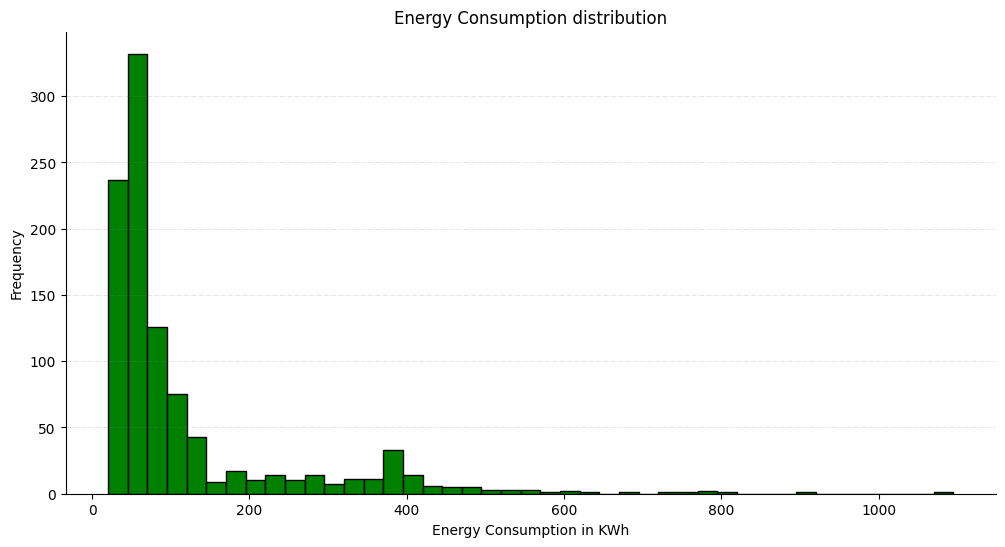

In [5]:
# define bins
min_a = min(df["Appliances"])
max_a = max(df["Appliances"])
binwidth = 25
bins = list(range(min_a, max_a + binwidth, binwidth))

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.hist(df["Appliances"], bins=bins,color="green", edgecolor="black")
ax.set_xlabel("Energy Consumption in KWh")
ax.set_ylabel("Frequency")
ax.set_title("Energy Consumption distribution")
ax.grid(visible=True, color="grey", linestyle="-.", linewidth=0.5, alpha=0.3, axis="y")
ax.spines["right"].set_visible(False) 
ax.spines["top"].set_visible(False) 
plt.show()

## SDV
Now, let's begin our analysis with the first package: SDV. To correctly use SDV, we first need to define the metadata for our dataset. This metadata will provide the necessary structural information and will be essential for generating synthetic data.

In [6]:
# Create Metadata
metadata = Metadata.detect_from_dataframe(
    data=df,
    table_name="Energy_consumption")

print(metadata)

{
    "tables": {
        "Energy_consumption": {
            "columns": {
                "date": {
                    "sdtype": "datetime",
                    "datetime_format": "%m/%d/%Y %H:%M"
                },
                "Appliances": {
                    "sdtype": "numerical"
                },
                "lights": {
                    "sdtype": "categorical"
                },
                "T1": {
                    "sdtype": "numerical"
                },
                "RH_1": {
                    "sdtype": "numerical"
                },
                "T2": {
                    "sdtype": "numerical"
                },
                "RH_2": {
                    "sdtype": "numerical"
                },
                "T3": {
                    "sdtype": "numerical"
                },
                "RH_3": {
                    "sdtype": "numerical"
                },
                "T4": {
                    "sdtype": "numerical"
                

After defining the metadata, we can now create the synthesizer. Below is a description of a synthesizer as provided in the SDV documentation:

"The SDV creates synthetic data using machine learning. A synthesizer is an object that facilitates this process.

1. First, a synthesizer is created based on the dataset's metadata.
2. Next, it is trained using real data, where it learns patterns and relationships from the original dataset.
3. Once trained, the synthesizer can generate new synthetic data that mimics the real dataset."

SDV offers different types of synthesizers, each using a distinct machine learning technique. In this study, we will evaluate three synthesizers (for SDV):

- GaussianCopulaSynthesizer: Uses classic statistical methods to model and generate synthetic data.
- CTGANSynthesizer: Uses Generative Adversarial Networks (GANs) to capture complex data distributions and generate synthetic data.
- TVAESynthesizer: Uses Variational Autoencoders (VAEs), a type of deep learning model, to learn and replicate data distributions.

Each of these synthesizers follows a different approach to generating synthetic data, allowing us to compare the effectiveness of traditional statistical methods versus deep learning techniques.

Let's begin with the GaussianCopulaSynthesizer, which uses statistical methods to generate synthetic data.

In [25]:
# Create the synthesizer
synthesizer_gaussian_SDV = GaussianCopulaSynthesizer(metadata)

# Training
synthesizer_gaussian_SDV.fit(df)

# Syntetic data generation
synthetic_data_gaussian_SDV = synthesizer_gaussian_SDV.sample(num_rows=1000) # 1000 Version
print(synthetic_data_gaussian_SDV)

# Save the data
synthetic_data_gaussian_SDV.to_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV_1000.csv", index=False)

                 date  Appliances  lights         T1       RH_1         T2  \
0    01/16/2016 23:39          76      20  20.120735  39.596775  19.228507   
1    01/18/2016 05:59         157      10  20.886849  40.614356  19.643012   
2    01/14/2016 23:43          47      20  18.705916  43.724254  17.939402   
3    01/17/2016 11:51          45       0  22.672339  40.408866  21.780287   
4    01/14/2016 01:26         202       0  18.484294  41.252604  17.783064   
..                ...         ...     ...        ...        ...        ...   
995  01/16/2016 05:42          29       0  20.075422  43.846417  18.722101   
996  01/15/2016 09:52          29       0  20.035384  45.021323  19.140262   
997  01/14/2016 00:14          59       0  21.609074  42.276179  20.461331   
998  01/12/2016 00:03         561      10  20.589254  45.484695  20.643470   
999  01/17/2016 03:35          23      10  22.474476  39.271384  21.393135   

          RH_2         T3   RH_3         T4  ...         T9    

Next, let's try the CTGANSynthesizer. Since this model benefits from GPU acceleration, this step will be executed in a separate Google Colab notebook to take advantage of the free GPU resources available. The code for this process is still provided below, and the synthetic data generated by the CTGANSynthesizer will be imported later in this notebook for further analysis.

In [26]:
# Create the synthesizer
synthesizer_CTGAN = CTGANSynthesizer(metadata)
# Training
synthesizer_CTGAN.fit(df)

# Syntetic data generation
synthetic_data_CTGAN = synthesizer_CTGAN.sample(num_rows=1000) # 1000 Version
print(synthetic_data_CTGAN)

# Save the data
synthetic_data_CTGAN.to_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV_1000.csv", index=False)

                 date  Appliances  lights         T1       RH_1         T2  \
0    01/13/2016 05:53          73      20  23.759575  39.590049  19.876674   
1    01/16/2016 18:12          61      40  19.730728  43.037925  17.700000   
2    01/16/2016 08:58         171      10  21.187676  38.555549  20.070326   
3    01/14/2016 06:38          54      30  23.524660  36.778442  19.218865   
4    01/15/2016 03:38          65      20  20.270739  55.893333  18.217401   
..                ...         ...     ...        ...        ...        ...   
995  01/16/2016 11:02         268       0  20.287607  39.986638  20.161077   
996  01/12/2016 15:06          90      20  23.650607  37.164804  22.790000   
997  01/17/2016 12:45         672      10  20.457841  44.454006  20.951733   
998  01/12/2016 10:01          38      10  21.694023  41.063333  17.700000   
999  01/11/2016 17:00          53      10  19.841452  38.881463  21.116351   

          RH_2         T3       RH_3         T4  ...         T9

The same process is applied to the TVAESynthesizer, with training performed in a separate Google Colab notebook for GPU acceleration. The generated synthetic data will be imported later for evaluation.

In [27]:
# Create the synthesizer
synthesizer_TVAE_SDV = TVAESynthesizer(metadata)

# Training
synthesizer_TVAE_SDV.fit(df)

# Syntetic data generation
synthetic_data_TVAE_SDV = synthesizer_TVAE_SDV.sample(num_rows=1000) # 1000 version

# Save the data
synthetic_data_TVAE_SDV.to_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV_1000.csv", index=False)

Before manually comparing the statistical similarity between the synthetic and real data, I will first utilize some of the built-in diagnostic and data validation functions provided by the SDV package. To begin, I will use the run_diagnostic function, which performs a basic validity check on each column and ensures that the overall structure of the dataset is preserved. According to the package documentation, this function should return a score of 100% if the dataset is correctly structured.

In [10]:
# Import the data created by the Three models (To not retrain the model everytime, and make the notebook run smothly)
synthetic_data_gaussian_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV.csv")
synthetic_data_CTGAN_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv")
synthetic_data_TVAE_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv")

print("Diagnostic Report for GaussianCopulaSynthesizer")
diagnostic_report_gaussian_SDV = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata)

print("Diagnostic Report for CTGANSynthesizer")
diagnostic_report_CTGAN_SDV = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata
)

print("Diagnostic Report for TVAESynthesizer")
diagnostic_report_TVAE_SDV = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata
)

Diagnostic Report for GaussianCopulaSynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 29/29 [00:00<00:00, 1519.45it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 11.63it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Diagnostic Report for CTGANSynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 29/29 [00:00<00:00, 2473.46it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 406.35it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%

Diagnostic Report for TVAESynthesizer
Generating report ...

(1/2) Evaluating Data Validity: |██████████| 29/29 [00:00<00:00, 2400.43it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 474.58it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



SDV also provides a function to generate a data quality report, which evaluates the statistical similarity between the real and synthetic data.

In [11]:
# Create the quality report for the three models
# Commented out to smoothing the notebook running
print("Quality Report for GaussianCopulaSynthesizer")
quality_report_gaussian_SDV = evaluate_quality(
    real_data=df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata)

print("Quality Report for CTGANSynthesizer")
quality_report_CTGAN_SDV = evaluate_quality(
    real_data=df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata
)

print("Quality Report for TVAESynthesizer")
quality_report_TVAE_SDV = evaluate_quality(
    real_data=df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata
)

# Save these results
quality_report_gaussian_SDV.save(filepath="Results_SDV/quality_report_gaussian.pkl")
quality_report_CTGAN_SDV.save(filepath="Results_SDV/quality_report_CTGAN.pkl")
quality_report_TVAE_SDV.save(filepath="Results_SDV/quality_report_TVAE.pkl")

Quality Report for GaussianCopulaSynthesizer
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 91.85it/s]|
Column Shapes Score: 89.18%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 258.64it/s]|
Column Pair Trends Score: 96.51%

Overall Score (Average): 92.85%

Quality Report for CTGANSynthesizer
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 52.66it/s]|
Column Shapes Score: 77.91%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 278.64it/s]|
Column Pair Trends Score: 87.36%

Overall Score (Average): 82.64%

Quality Report for TVAESynthesizer
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 92.87it/s]| 
Column Shapes Score: 88.66%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 281.44it/s]|
Column Pair Trends Score: 94.94%

Overall Score (Average): 91.8%



Another feature offered by SDV is the ability to visualize the data in 2D. This helps in identifying the patterns learned by the synthetic data and spotting differences between the real and synthetic distributions.

In [16]:
# Plot for the GaussianCopulaSynthesizer
fig_gaussian_SDV = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_gaussian_SDV,
    metadata=metadata,
    column_name="Appliances"
)
    
fig_gaussian_SDV.show()

In [13]:
# Plot for the CTGAN model
fig_CTGAN_SDV = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_CTGAN_SDV,
    metadata=metadata,
    column_name="Appliances"
)
    
fig_CTGAN_SDV.show()

In [14]:
# Plot for the TVAESynthesizer model
fig_TVAE_SDV = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_TVAE_SDV,
    metadata=metadata,
    column_name="Appliances"
)
    
fig_TVAE_SDV.show()

## Synthcity 
Now, let's begin analyzing Synthcity. Unlike SDV, it does not offer as many built-in functionalities, so I will focus on using the models it provides. In particular, I will evaluate the following synthesizers:

- Bayesian Network Synthesizer – Similar to Gaussian Copula, it relies on statistical methods rather than deep learning.
- CTGAN – The same GAN-based model as the one used in SDV.
- TVAE – The same VAE-based model as the one used in SDV.

Just like with the SDV models, I will train these Synthcity models in a separate notebook. However, the code is still provided below.

In [28]:
# Check available models
print(Plugins().list())

# Create Bayesian Network Model (Comparison with SDV GaussianCopula)
synthesizer_bayes_net_SYN = Plugins().get("bayesian_network")
print("Model initialized Successfully")

# Train on real data (TRAIN ON GPU)
synthesizer_bayes_net_SYN.fit(df)

# Generate synthetic data
synthetic_data_bayes_net_SYN = synthesizer_bayes_net_SYN.generate(1000).dataframe() # 1000 version

# Save the data
synthetic_data_bayes_net_SYN.to_csv("Datasets/SyntheticData/synthetic_data_bayes_net_SYN_1000.csv", index=False)

# Model to compare
# GaussianCopula VS bayesian_network (Both probabilistic models)
# CTGAN VS ctgan (Exact match)
# TVAE VS tvae (Exact Match)

[2025-04-06T02:46:18.530934+0200][30616][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_bayesian_network' has no attribute 'plugin'
[2025-04-06T02:46:18.533935+0200][30616][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_bayesian_network' has no attribute 'plugin'
[2025-04-06T02:46:18.535933+0200][30616][CRITICAL] module plugin_bayesian_network load failed
[2025-04-06T02:46:18.539934+0200][30616][CRITICAL] module disabled: c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
[2025-04-06T02:46:18.548971+0200][30616][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_aim' has no attribute 'plugin'
[2025-04-06T02:46:18.551403+0200][30616][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_aim' has no attribute 'plugin'


[2025-04-06T02:46:18.552401+0200][30616][CRITICAL] module plugin_aim load failed
[2025-04-06T02:46:18.553402+0200][30616][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-04-06T02:46:18.554402+0200][30616][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-04-06T02:46:18.554402+0200][30616][CRITICAL] module plugin_decaf load failed
[2025-04-06T02:46:18.558404+0200][30616][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_privbayes' has no attribute 'plugin'
[2025-04-06T02:46:18.559403+0200][30616][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_privbayes' has no attribute 'plugin'
[2025-04-06T02:46:18.559403+0200][30616][CRITICAL] module plugin_privbayes load failed
[2025-04-06T02:46:18.573156+0200][30616][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_bayesian_network' has no attribute 'plugin'
[2025-04-06T02:46:18.574154+0200][30616]

['timevae', 'adsgan', 'great', 'timegan', 'marginal_distributions', 'dpgan', 'survival_gan', 'survae', 'arf', 'rtvae', 'image_adsgan', 'tvae', 'radialgan', 'pategan', 'dummy_sampler', 'nflow', 'fflows', 'survival_ctgan', 'image_cgan', 'ddpm', 'survival_nflow', 'ctgan', 'uniform_sampler']


ValueError: Plugin bayesian_network doesn't exist.

In [29]:
# Create Conditional GAN (Comparison with SDV CTGAN)
synthesizer_ctgan_SYN = Plugins().get("ctgan")

# Train the model
synthesizer_ctgan_SYN.fit(df)

# Create and save the data
synthetic_data_ctgan_SYN = synthesizer_ctgan_SYN.generate(1000).dataframe() # 1000 version
synthetic_data_ctgan_SYN.to_csv("Datasets/SyntheticData/synthetic_data_ctgan_SYN_1000.csv", index=False)

[2025-04-06T02:46:45.733671+0200][30616][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_bayesian_network' has no attribute 'plugin'
[2025-04-06T02:46:45.734673+0200][30616][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_bayesian_network' has no attribute 'plugin'
[2025-04-06T02:46:45.735670+0200][30616][CRITICAL] module plugin_bayesian_network load failed
[2025-04-06T02:46:45.736676+0200][30616][CRITICAL] module disabled: c:\Users\Utente\OneDrive\Desktop\DS Class Project\.venv\Lib\site-packages\synthcity\plugins\generic\plugin_goggle.py
[2025-04-06T02:46:45.737672+0200][30616][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_aim' has no attribute 'plugin'
[2025-04-06T02:46:45.737672+0200][30616][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_aim' has no attribute 'plugin'
[2025-04-06T02:46:45.738773+0200][30616][CRITICAL] module plugin_aim load failed
[2025-04-06T02:46:45.739791+0200][30616][CRITICAL] load failed: module

KeyboardInterrupt: 

In [ ]:
# Create Triplet-Based Variational Autoencoder (Comparison with SDV TVAE)
synthesizer_tvae_SYN = Plugins().get("tvae")

# Train the model
synthesizer_tvae_SYN.fit(df)

# Create synthetic and save them
synthetic_data_tvae_SYN = synthesizer_tvae_SYN.generate(10000).dataframe()
synthetic_data_tvae_SYN.to_csv("Datasets/SyntheticData/synthetic_data_tvae_SYN.csv", index=False)

## Statistical Analysis of Real vs. Synthetic Datasets

In this section, we compare the predictive utility of synthetic data in two scenarios:

1) 1:1 Ratio: The data generators are trained on the first 1,000 rows of the real dataset and tasked with generating 1,000 synthetic rows. This maintains a one-to-one ratio between input and output data.

2) 1:10 Ratio: The same 1,000 real rows are used for training, but the generators are now asked to produce 10,000 synthetic rows, resulting in a one-to-ten input-to-output ratio.

We expect significantly better performance in the 1:1 scenario, as the generators are not required to extrapolate far beyond the scale of the original data. In contrast, the 1:10 scenario is more challenging and likely to reveal the limitations of each model when attempting to synthesize data at a larger scale from a small training sample.

## 1:1 Ratio Comparison

First, for a quick comparison, let's use the built-in functions provided by SDV.

In [18]:
# Import all the necessary datasets
real_df = pd.read_csv("Datasets/energydata_complete.csv", nrows=1000) 
# NOT USING nrows=100 to use a random subset of the data by sampling
#real_df = real_df.sample(n=1000)
synthetic_data_gaussian_SDV_1000 = pd.read_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV_1000.csv") # 100o rows versions
synthetic_data_CTGAN_SDV_1000 = pd.read_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV_1000.csv")
synthetic_data_TVAE_SDV_1000 = pd.read_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV_1000.csv")
synthetic_data_bayes_net_SYN_1000 = pd.read_csv("Datasets/SyntheticData/synthetic_data_bayes_net_SYN_1000.csv")
synthetic_data_ctgan_SYN_1000 = pd.read_csv("Datasets/SyntheticData/synthetic_data_ctgan_SYN_1000.csv")
synthetic_data_tvae_SYN_1000 = pd.read_csv("Datasets/SyntheticData/synthetic_data_tvae_SYN_1000.csv")

# Evaluate quality with SDV built in package
print("Quality Report for GaussianCopulaSynthesizer SDV")
quality_report_gaussian_SDV = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_gaussian_SDV_1000,
    metadata=metadata)

print("Quality Report for CTGANSynthesizer SDV")
quality_report_CTGAN_SDV = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_CTGAN_SDV_1000,
    metadata=metadata
)

print("Quality Report for TVAESynthesizer SDV")
quality_report_TVAE_SDV = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_TVAE_SDV_1000,
    metadata=metadata
)


Quality Report for GaussianCopulaSynthesizer SDV
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 524.01it/s]|
Column Shapes Score: 88.48%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 317.54it/s]|
Column Pair Trends Score: 95.96%

Overall Score (Average): 92.22%

Quality Report for CTGANSynthesizer SDV
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 603.42it/s]|
Column Shapes Score: 79.99%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 337.64it/s]|
Column Pair Trends Score: 87.08%

Overall Score (Average): 83.53%

Quality Report for TVAESynthesizer SDV
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 1067.01it/s]|
Column Shapes Score: 88.27%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 340.18it/s]|
Column Pair Trends Score: 94.73%

Overall Score (Average): 91.5%



In [43]:
print("Quality Report for Bayesian Network SYN")
quality_report_bayes_net_SYN = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_bayes_net_SYN,
    metadata=metadata
)

print("Quality Report for ctgan SYN")
quality_report_ctgan_SYN = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_ctgan_SYN,
    metadata=metadata
)

print("Quality Report for tvae SYN")
quality_report_tvae_SYN = evaluate_quality(
    real_data=real_df,
    synthetic_data=synthetic_data_tvae_SYN,
    metadata=metadata
)

Quality Report for Bayesian Network SYN
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 646.11it/s]|
Column Shapes Score: 95.14%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 343.65it/s]|
Column Pair Trends Score: 98.09%

Overall Score (Average): 96.61%

Quality Report for ctgan SYN
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 1047.30it/s]|
Column Shapes Score: 83.96%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 305.18it/s]|
Column Pair Trends Score: 94.97%

Overall Score (Average): 89.46%

Quality Report for tvae SYN
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 29/29 [00:00<00:00, 1049.93it/s]|
Column Shapes Score: 83.34%

(2/2) Evaluating Column Pair Trends: |██████████| 406/406 [00:01<00:00, 290.95it/s]|
Column Pair Trends Score: 92.2%

Overall Score (Average): 87.77%



Let's now visualize the distribution differences for the "Appliances" column in each real and synthetic dataset, too see how well the synthetic data resemble the real data distribution.

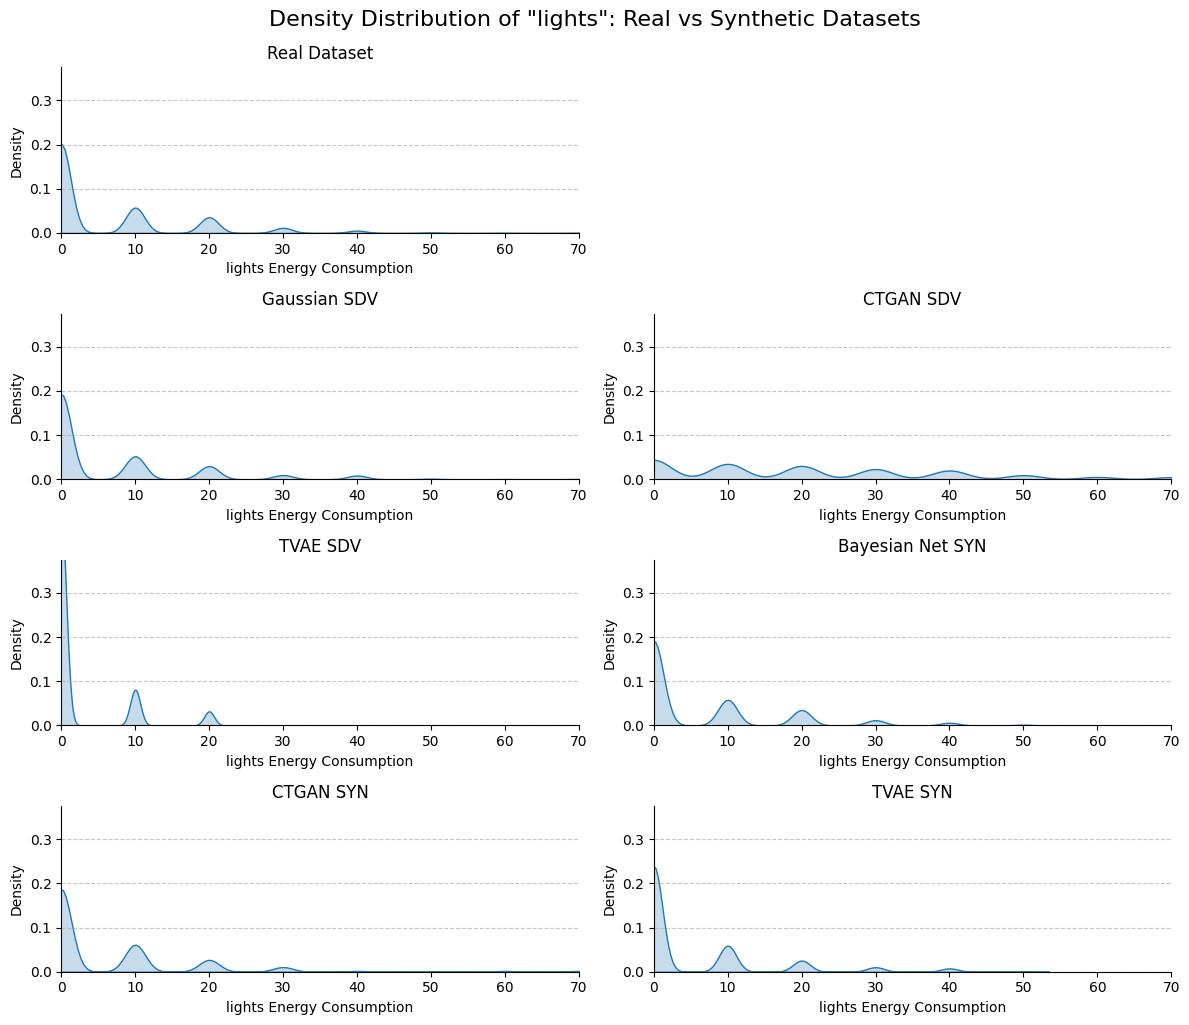

In [19]:
fig, ax = plt.subplots(4, 2, figsize=(12, 10))

column_to_visualize = "lights"

# Define common x-axis range from real data
xmin = real_df[column_to_visualize].min()
xmax = real_df[column_to_visualize].max()

# Create the density plots
sns.kdeplot(real_df[column_to_visualize], fill=True, ax=ax[0, 0], bw_adjust=0.5)
ax[0, 0].set_title("Real Dataset")
fig.delaxes(ax[0, 1])

sns.kdeplot(synthetic_data_gaussian_SDV_1000[column_to_visualize], fill=True, ax=ax[1, 0], bw_adjust=0.5)
ax[1, 0].set_title("Gaussian SDV")

sns.kdeplot(synthetic_data_CTGAN_SDV_1000[column_to_visualize], fill=True, ax=ax[1, 1], bw_adjust=0.5)
ax[1, 1].set_title("CTGAN SDV")

sns.kdeplot(synthetic_data_TVAE_SDV_1000[column_to_visualize], fill=True, ax=ax[2, 0], bw_adjust=0.5)
ax[2, 0].set_title("TVAE SDV")

sns.kdeplot(synthetic_data_bayes_net_SYN_1000[column_to_visualize], fill=True, ax=ax[2, 1], bw_adjust=0.5)
ax[2, 1].set_title("Bayesian Net SYN")

sns.kdeplot(synthetic_data_ctgan_SYN_1000[column_to_visualize], fill=True, ax=ax[3, 0], bw_adjust=0.5)
ax[3, 0].set_title("CTGAN SYN")

sns.kdeplot(synthetic_data_tvae_SYN_1000[column_to_visualize], fill=True, ax=ax[3, 1], bw_adjust=0.5)
ax[3, 1].set_title("TVAE SYN")

for axes in ax.flat:
    axes.spines["top"].set_visible(False)
    axes.spines["right"].set_visible(False)
    axes.grid(axis="y", linestyle="--", alpha=0.7)
    axes.set_xlabel(f"{column_to_visualize} Energy Consumption")
    axes.set_ylabel("Density")
    axes.set_xlim(xmin, xmax)
    axes.set_ylim(0, 0.25 * 1.5)  # * 1.35 to show even the highest peak

fig.tight_layout()
fig.suptitle(f"Density Distribution of \"{column_to_visualize}\": Real vs Synthetic Datasets", fontsize=16, y=1.02)
plt.show()


To systematically compare the statistical similarity between real and synthetic datasets, I implemented a custom function called overall_similarity. This function evaluates how closely the synthetic data resembles the real data by computing normalized differences in key statistical properties.

The function considers classic statistical measures (mean, median, mode, standard deviation, variance) along with distributional similarity metrics, Kolmogorov-Smirnov (KS) test and Wasserstein distance. These two distribution-based metrics were specifically chosen because they are used internally by SDV’s built-in evaluation functions, as seen in the SDV source code.

The similarity score is computed by applying weighted penalties for statistical deviations, meaning that lower discrepancies between real and synthetic data lead to a higher score. The final output is a percentage-based score (0 to 100), where 100 indicates perfect similarity.

In [20]:
# Create the function
def overall_similarity(real_df, synthetic_df, 
                       weight_mean=0.3, weight_median=0.2, weight_mode=0.1, weight_sd=0.1, weight_var=0.1,
                       weight_ks=0.2, weight_wasserstein=0.1):
    """
    Computes an overall similarity score between real and synthetic datasets based
    on normalized differences in mean, median (if numerical) and mode (if categorical) across columns.

    Parameters:
    - real_df (pd.DataFrame): Real dataset
    - synthetic_df (pd.DataFrame): Synthetic dataset
    - weight_mean (float, optional): Weight for mean difference. Defaults to 0.3.
    - weight_median (float, optional): Weight for median difference. Defaults to 0.3.
    - weight_mode (float, optional): Weight for mode difference. Defaults to 0.2.
    - weight_sd (float, optional): Weight for standard deviation difference. Defaults to 0.1
    - weight_var (float, optional): Weight for variance difference. Defaults to 0.1

    Returns:
    Returns a score between 0 and 100, where 100 indicates perfect similarity.
    """

    # Drop datetime columns
    real_df = real_df.select_dtypes(exclude=["datetime64"])
    synthetic_df = synthetic_df.select_dtypes(exclude=["datetime64"])

    scores = []
    common_cols = set(real_df.columns).intersection(set(synthetic_df.columns))

    for col in common_cols:
        # Check if numerical
        if pd.api.types.is_numeric_dtype(real_df[col]):
            # Classic statistics
            real_mean, syn_mean = real_df[col].mean(), synthetic_df[col].mean() 
            real_median, syn_median = real_df[col].median(), synthetic_df[col].median()
            real_sd, syn_sd = real_df[col].std(), synthetic_df[col].std()
            real_var, syn_var = real_df[col].var(), synthetic_df[col].var()
            
            # Avoid division by zero
            norm_mean = min(1, abs(real_mean - syn_mean) / (abs(real_mean) + 1e-6))
            norm_median = min(1, abs(real_median - syn_median) / (abs(real_median) + 1e-6))
            norm_sd = min(1, abs(real_sd - syn_sd) / (abs(real_sd) + 1e-6))
            norm_var = min(1, abs(real_var - syn_var) / (abs(real_var) + 1e-6))
      
            # Kolmogorov-Smirnov Test (Checks if distributions are similar)
            ks_stat, _ = ks_2samp(real_df[col].dropna(), synthetic_df[col].dropna())
        
            # Wasserstein Distance (Lower means closer distributions)
            wasserstein_dist = wasserstein_distance(real_df[col].dropna(), synthetic_df[col])
            norm_wasserstein = 1 / (1 + wasserstein_dist) # now between 0 and 1

            col_score = 1 - (weight_mean * norm_mean + 
                             weight_median * norm_median + 
                             weight_sd * norm_sd + 
                             weight_var * norm_var +
                             weight_ks * ks_stat + 
                             weight_wasserstein * (1 - norm_wasserstein))
        
        else:
            real_mode = real_df[col].mode()
            syn_mode = synthetic_df[col].mode()
            if not real_mode.empty and not syn_mode.empty:
                mode_score = 1.0 if real_mode.iloc[0] == syn_mode.iloc[0] else 0.0
            else:
                mode_score = 0.0
            col_score = mode_score* weight_mode
        
        scores.append(col_score)
    
    overall_score = np.mean(scores) * 100
    return round(overall_score, 2)


Test the function on different subset of the same (real) dataset, the score should be close to 100.

In [21]:
# Split the real dataset in two random subsets
real_data_part_1, real_data_part_2 = train_test_split(real_df, test_size=0.5, random_state=1618)

# Evaluate the two parts on the statistical function
sim_score_test = overall_similarity(real_data_part_1, real_data_part_2)
print(f"Similarity score: {sim_score_test}")

# The score is perfectly 100% if tested on the exact same data, as wanted
sim_score_test = overall_similarity(real_data_part_1, real_data_part_1)
print(f"Similarity score: {sim_score_test}")

Similarity score: 95.66
Similarity score: 100.0


Evaluate the datasets based on this function.

In [22]:
sim_score_gaussian_SDV_1000 = overall_similarity(real_df, synthetic_data_gaussian_SDV_1000, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with Gaussian SDV: ", sim_score_gaussian_SDV_1000)

sim_score_CTGAN_SDV_1000 = overall_similarity(real_df, synthetic_data_CTGAN_SDV_1000, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with CTGAN SDV: ", sim_score_CTGAN_SDV_1000)

sim_score_TVAE_SDV_1000 = overall_similarity(real_df, synthetic_data_TVAE_SDV_1000, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with TVAE SDV: ", sim_score_TVAE_SDV_1000)

sim_score_bayes_net_SYN_1000 = overall_similarity(real_df, synthetic_data_bayes_net_SYN_1000, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with Bayes Net SYN: ", sim_score_bayes_net_SYN_1000)

sim_score_ctgan_SYN_1000 = overall_similarity(real_df, synthetic_data_ctgan_SYN_1000, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with CTGAN SYN: ", sim_score_ctgan_SYN_1000)

sim_score_tvae_SYN_1000 =  overall_similarity(real_df, synthetic_data_tvae_SYN_1000, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with TVAE SYN: ", sim_score_tvae_SYN_1000)

Similarity between real data and synthetic data with Gaussian SDV:  91.98
Similarity between real data and synthetic data with CTGAN SDV:  80.28
Similarity between real data and synthetic data with TVAE SDV:  87.38
Similarity between real data and synthetic data with Bayes Net SYN:  96.53
Similarity between real data and synthetic data with CTGAN SYN:  88.37
Similarity between real data and synthetic data with TVAE SYN:  86.26


## Evaluating Predictive Utility

This step aims to compare how well machine learning models trained on real data perform against those trained on synthetic data. The goal is not to optimize model performance but to assess how closely the synthetic data preserves the predictive characteristics of the real dataset. 

To assess how well synthetic data preserves the predictive properties of real data, the function in the following codeblock trains multiple machine learning models on both real and synthetic datasets and stores the results in a structured format.

Rather than directly comparing the performances, the function organizes the evaluation metrics (MAE, MSE, R²) into three key outputs:

- real_metrics_df – The performance of ML models trained on real data.
- detailed_syn_metrics – The performance of ML models trained on each synthetic dataset, stored in a nested dictionary for granular analysis.
- overall_syn_metrics_df – The average performance of each synthetic data generator across all ML models, making it easier to analyze general trends.

This structured output allows for further comparisons and analysis in subsequent steps, where we can examine the differences between real and synthetic data performances.

In [23]:
# Divide all the datasets in training and targets
X_real = real_df.drop(["Appliances", "date"], axis=1)
y_real = real_df["Appliances"]

X_gaussian_SDV = synthetic_data_gaussian_SDV_1000.drop(["Appliances", "date"], axis=1)
y_gaussian_SDV = synthetic_data_gaussian_SDV_1000["Appliances"]

X_bayes_net_SYN = synthetic_data_bayes_net_SYN_1000.drop(["Appliances", "date"], axis=1)
y_bayes_net_SYN = synthetic_data_bayes_net_SYN_1000["Appliances"]

X_CTGAN_SDV = synthetic_data_CTGAN_SDV_1000.drop(["Appliances", "date"], axis=1)
y_CTGAN_SDV = synthetic_data_CTGAN_SDV_1000["Appliances"]

X_ctgan_SYN = synthetic_data_ctgan_SYN_1000.drop(["Appliances", "date"], axis=1)
y_ctgan_SYN = synthetic_data_ctgan_SYN_1000["Appliances"]

X_TVAE_SDV = synthetic_data_TVAE_SDV_1000.drop(["Appliances", "date"], axis=1)
y_TVAE_SDV = synthetic_data_TVAE_SDV_1000["Appliances"]

X_tvae_SYN = synthetic_data_tvae_SYN_1000.drop(["Appliances", "date"], axis=1)
y_tvae_SYN = synthetic_data_tvae_SYN_1000["Appliances"]

synthetic_datasets = {
    "Gaussian SDV": (X_gaussian_SDV, y_gaussian_SDV),
    "Bayes Net SYN": (X_bayes_net_SYN, y_bayes_net_SYN),
    "CTGAN SDV": (X_CTGAN_SDV, y_CTGAN_SDV),
    "CTGAN SYN": (X_ctgan_SYN, y_ctgan_SYN),
    "TVAE SDV": (X_TVAE_SDV, y_TVAE_SDV),
    "TVAE SYN": (X_tvae_SYN, y_tvae_SYN)
}

models = {
    "XGB": XGBRegressor(colsample_bytree = 0.8, 
                     gamma = 0, learning_rate = 0.1, 
                     max_depth = 5, 
                     n_estimators = 100, 
                     subsample = 1.0, 
                     random_state=1618),
    "RF": RandomForestRegressor(max_depth=40, max_features="sqrt", n_estimators=240),
    "SVR": SVR(C=8, gamma=1, kernel="rbf"),
    "Linear": LinearRegression()
}

def evaluate_all_models(X_real, y_real, synthetic_datasets, models, test_size=0.2, random_state=1618, repeats=10):
    """
    Evaluate all models on all synthetic datasets using repeated holdout for robust results.

    Parameters:
    - X_real (pd.DataFrame): Features from the real dataset
    - y_real (pd.Series): Target variable from the real dataset
    - synthetic_datasets (dict): Dictionary of synthetic datasets
    - models (dict): Dictionary of models to evaluate
    - test_size (float, optional): Proportion of data to use for testing. Defaults to 0.2.
    - random_state (int, optional): Seed for random number generation. Defaults to 1618
    - repeats (int, optional): Number of random splits of the data for statistical significant results. Defaults to 1

    Returns:
    - real_metrics_df (pd.DataFrame): Evaluation metrics for each model on real data
    - overall_syn_metrics_df (pd.DataFrame): Average Evaluation metrics
    - detailed_syn_metrics (dict): Nested dictionary of metrics for each synthetic data generator 
    """

    # Scale the data
    scaler = StandardScaler()
    X_real_scaled = scaler.fit_transform(X_real)

    # Dictionaries to hold repeated metrics
    real_metrics_accum = {model_name: [] for model_name in models}
    detailed_syn_metrics_accum = {method: {model_name: [] for model_name in models} for method in synthetic_datasets}

    # Repeated holdouts
    for i in range(repeats):
        current_seed = random_state + i # change random state everytime to evaluate different part of the dataframe

        # Split real data
        X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
            X_real_scaled, y_real, test_size=test_size, random_state=current_seed
        )

        # Evaluate all models on real data
        for model_name, model in models.items():
            model_clone = clone(model)
            model_clone.fit(X_train_real, y_train_real)
            y_pred_real = model_clone.predict(X_test_real)

            real_metrics_accum[model_name].append({
                "MAE": mean_absolute_error(y_test_real, y_pred_real),
                "MSE": mean_squared_error(y_test_real, y_pred_real),
                "R2": r2_score(y_test_real, y_pred_real)
            })
        
        # Evaluate synthetic data 
        for method, (X_syn, y_syn) in synthetic_datasets.items():
            X_syn_scaled = scaler.transform(X_syn)

            # Split the syn data (To ensure same proportions)
            X_train_syn, _ , y_train_syn, _ = train_test_split(
                X_syn_scaled, y_syn, test_size=test_size, random_state=current_seed
            )

            for model_name, model in models.items():
                model_clone = clone(model)
                model_clone.fit(X_train_syn, y_train_syn)
                y_pred_syn = model_clone.predict(X_test_real) # Test on REAL data
                
                # Test everything on REAL data
                detailed_syn_metrics_accum[method][model_name].append({
                    "MAE": mean_absolute_error(y_test_real, y_pred_syn),
                    "MSE": mean_squared_error(y_test_real, y_pred_syn),
                    "R2": r2_score(y_test_real, y_pred_syn)
                })
    
    # Avarege all the results
    real_metrics = {
        model_name: {
            metric: np.mean([res[metric] for res in results])
            for metric in ["MAE", "MSE", "R2"]
        }
        for model_name, results in real_metrics_accum.items()
    }

    real_metrics_df = pd.DataFrame(real_metrics).T

    # Same for synthetic data
    detailed_syn_metrics = {
        method: {
            model_name: {
                metric: np.mean([res[metric] for res in results])
                for metric in ["MAE", "MSE", "R2"]
            }
            for model_name, results in model_dict.items()
        }
        for method, model_dict in detailed_syn_metrics_accum.items()
    }

    # Compute overall avareges for synthetic data
    overall_syn_metrics = {
        method: {
            "MAE_avg": np.mean([metrics["MAE"] for metrics in model_dict.values()]),
            "MSE_avg": np.mean([metrics["MSE"] for metrics in model_dict.values()]),
            "R2_avg": np.mean([metrics["R2"] for metrics in model_dict.values()]),
        }
        for method, model_dict in detailed_syn_metrics.items()
    }

    overall_syn_metrics_df = pd.DataFrame(overall_syn_metrics).T # Transpose to have metrics as columns

    return real_metrics_df, overall_syn_metrics_df, detailed_syn_metrics

Test the function on same dataset to ensure reliability (The performances should be very similar)

In [37]:
# Create fake dictionary
real_data_dict = {
    "Real_Data": (X_real, y_real)
}

# Evaluate function
real_metric_1, real_metric_2, _ = evaluate_all_models(X_real, y_real, real_data_dict, models, test_size=0.2, random_state=1618, repeats=10)
real_metric_2.to_csv("Metrics_performances/TEST_EQUAL_TO_REAL.csv", index=False)
print(real_metric_1.mean()[["MAE", "MSE", "R2"]])
print(real_metric_2.head())

MAE       58.697169
MSE    11641.722008
R2         0.324613
dtype: float64
             MAE_avg       MSE_avg   R2_avg
Real_Data  58.714252  11626.832061  0.32521


Now, let's use the function to generate the structured DataFrames needed for further analysis and comparison.

In [24]:
# Create the metrics datasets
real_metrics_df, overall_syn_metrics_df, detailed_syn_metrics = evaluate_all_models(X_real, y_real, synthetic_datasets, models, test_size=0.2, random_state=1618, repeats=10)

real_metrics_df.to_csv("Metrics_performances/real_metrics.csv", index=False)
overall_syn_metrics_df.to_csv("Metrics_performances/overall_syn_metrics_1000.csv", index=False)
print(real_metrics_df.head())
print(overall_syn_metrics_df.head())
print(detailed_syn_metrics)

              MAE           MSE        R2
XGB     47.695482   7303.067236  0.574553
RF      48.135880   7320.069930  0.575378
SVR     67.121140  19265.215993 -0.115618
Linear  72.185574  12708.101914  0.261227
                  MAE_avg       MSE_avg    R2_avg
Gaussian SDV    71.484748  16400.565088  0.050023
Bayes Net SYN   57.602302  11917.782323  0.310657
CTGAN SDV      118.069808  23282.255486 -0.360860
CTGAN SYN       96.328787  18523.870155 -0.081789
TVAE SDV        67.656850  17335.382258 -0.002818
{'Gaussian SDV': {'XGB': {'MAE': 71.88560218811035, 'MSE': 15401.11865234375, 'R2': 0.10735938549041749}, 'RF': {'MAE': 73.96833124999999, 'MSE': 15817.203663185763, 'R2': 0.08376844582016765}, 'SVR': {'MAE': 72.33383450305257, 'MSE': 19976.05252136896, 'R2': -0.15691870144190295}, 'Linear': {'MAE': 67.75122548026181, 'MSE': 14407.885513394405, 'R2': 0.1658821519869182}}, 'Bayes Net SYN': {'XGB': {'MAE': 46.884688186645505, 'MSE': 7624.126123046875, 'R2': 0.5608651041984558}, 'RF': {'M

Compute the absolute and relative differences between the performances of ML models on real and synthetic data. The smaller the difference, the better the synthetic data replicates the characteristics of the real dataset. It is important to note that we are not trying to identify the model that achieves the best performance but rather the synthetic data generator that produces results most aligned with those obtained from real data.

In [25]:
# Import dataframes
real_metrics_df = pd.read_csv("Metrics_performances/real_metrics.csv")
overall_syn_metrics_df = pd.read_csv("Metrics_performances/overall_syn_metrics_1000.csv")
TEST = pd.read_csv("Metrics_performances/TEST_EQUAL_TO_REAL.csv")

# Compute the differences
diff_metrics_1000 = overall_syn_metrics_df.copy()
diff_metrics_TEST = TEST.copy()
print(overall_syn_metrics_df.index)

# Absolute difference
for metric in ["MAE", "MSE", "R2"]:
    diff_metrics_1000[f"Delta_{metric}"] = abs(real_metrics_df.mean()[metric] - overall_syn_metrics_df[f"{metric}_avg"])

# TEST
for metric in ["MAE", "MSE", "R2"]:
    diff_metrics_TEST[f"Delta_TEST_{metric}"] = abs(real_metrics_df.mean()[metric] - TEST[f"{metric}_avg"])

# Percentages, relative difference
for metric in ["MAE", "MSE"]:
    diff_metrics_1000[f"Real_Delta_{metric} (%)"] = (diff_metrics_1000[f"Delta_{metric}"] / (real_metrics_df.mean()[metric])) * 100

# For R2 the difference is simplier since it's already a percentage
diff_metrics_1000["Real_Delta_R2 (%)"] = (diff_metrics_1000["Delta_R2"] / (real_metrics_df.mean()["R2"])) * 100 # CHECK HERE

model_names = ["Gaussian SDV", "Bayesian Net SYN", "CTGAN SDV", "ctgan SYN", "TVAE SDV", "tvae SYN"]
diff_metrics_1000.index = model_names
print(diff_metrics_1000.index)

print(diff_metrics_1000)
print(diff_metrics_TEST)


RangeIndex(start=0, stop=6, step=1)
Index(['Gaussian SDV', 'Bayesian Net SYN', 'CTGAN SDV', 'ctgan SYN',
       'TVAE SDV', 'tvae SYN'],
      dtype='object')
                     MAE_avg       MSE_avg    R2_avg  Delta_MAE     Delta_MSE  \
Gaussian SDV       71.484748  16400.565088  0.050023  12.700229   4751.451319   
Bayesian Net SYN   57.602302  11917.782323  0.310657   1.182217    268.668554   
CTGAN SDV         118.069808  23282.255486 -0.360860  59.285289  11633.141717   
ctgan SYN          96.328787  18523.870155 -0.081789  37.544268   6874.756387   
TVAE SDV           67.656850  17335.382258 -0.002818   8.872331   5686.268490   
tvae SYN           79.497514  16535.274564  0.038788  20.712994   4886.160796   

                  Delta_R2  Real_Delta_MAE (%)  Real_Delta_MSE (%)  \
Gaussian SDV      0.273862           21.604717           40.788093   
Bayesian Net SYN  0.013228            2.011103            2.306343   
CTGAN SDV         0.684745          100.851873           99.862

Visualize the results using a bar plot to compare the percentage differences between real and synthetic data across the three evaluation metrics (MAE, MSE, and R²). 

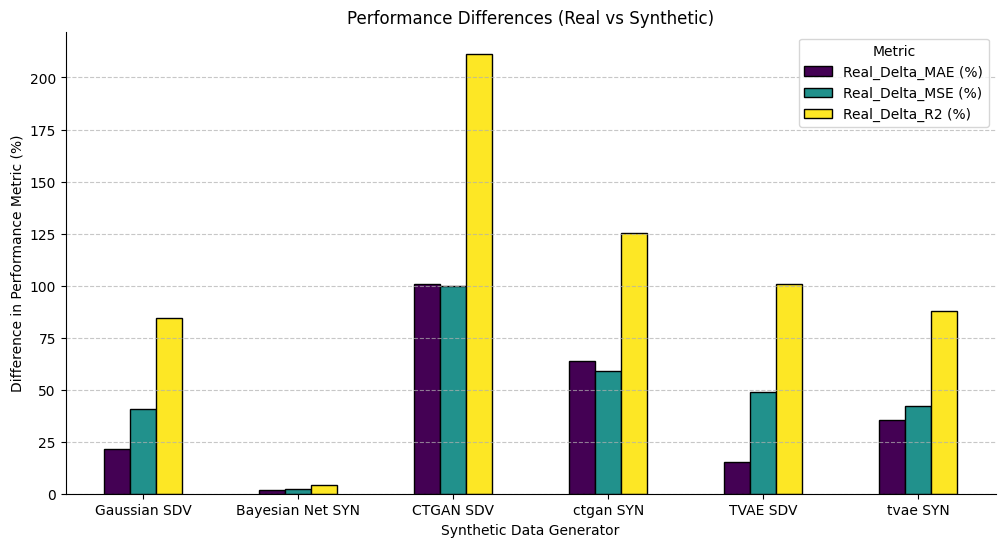

In [26]:
metrics = ["Real_Delta_MAE (%)", "Real_Delta_MSE (%)", "Real_Delta_R2 (%)"]

fig, ax = plt.subplots(figsize=(12,6))
# Plot bar chart
diff_metrics_1000[metrics].plot(kind="bar", ax=ax, colormap="viridis", edgecolor="black")

ax.set_title("Performance Differences (Real vs Synthetic)")
ax.set_ylabel("Difference in Performance Metric (%)")
ax.set_xlabel("Synthetic Data Generator")
ax.set_xticklabels(diff_metrics_1000.index, rotation=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend(title="Metric")
plt.show()


To get a clearer picture of which synthetic data generator overall produces data that best aligns with the performance of real data across different ML models, we create a single aggregated metric that combines MAE, MSE, and R².

     MAE_avg       MSE_avg   R2_avg  Delta_TEST_MAE  Delta_TEST_MSE  \
0  58.714252  11626.832061  0.32521        0.070267       22.281707   

   Delta_TEST_R2  MAE_Score  MSE_Score  R2_Score  
0       0.001325   0.998805   0.998087   0.99591  
                  MAE_Score  MSE_Score  R2_Score
Bayesian Net SYN   0.979889   0.976937  0.959159
Gaussian SDV       0.783953   0.592119  0.154446
TVAE SDV           0.849070   0.511871 -0.008702
tvae SYN           0.647645   0.580555  0.119759
ctgan SYN          0.361324   0.409847 -0.252524
CTGAN SDV         -0.008519   0.001371 -1.114159
Bayesian Net SYN    0.971995
Gaussian SDV        0.510173
TVAE SDV            0.450746
tvae SYN            0.449320
ctgan SYN           0.172882
CTGAN SDV          -0.373769
Name: Overall_Score, dtype: float64
0    0.997601
Name: Overall_Score, dtype: float64


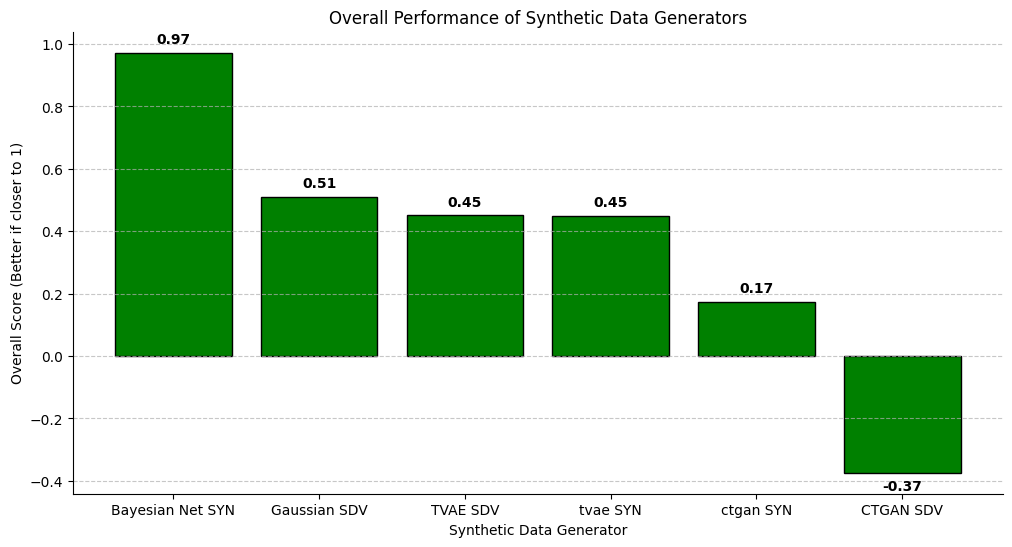

In [27]:
# Calculate the scores
diff_metrics_1000["MAE_Score"] = 1 - (diff_metrics_1000["Delta_MAE"] / real_metrics_df.mean()["MAE"]) 
diff_metrics_1000["MSE_Score"] = 1 - (diff_metrics_1000["Delta_MSE"] / real_metrics_df.mean()["MSE"])
diff_metrics_1000["R2_Score"] = 1 - (diff_metrics_1000["Delta_R2"] / real_metrics_df.mean()["R2"])

# TEST
diff_metrics_TEST["MAE_Score"] = 1 - (diff_metrics_TEST["Delta_TEST_MAE"] / real_metrics_df.mean()["MAE"])
diff_metrics_TEST["MSE_Score"] = 1 - (diff_metrics_TEST["Delta_TEST_MSE"] / real_metrics_df.mean()["MSE"])
diff_metrics_TEST["R2_Score"] = 1 - (diff_metrics_TEST["Delta_TEST_R2"] / real_metrics_df.mean()["R2"])
print(diff_metrics_TEST)

# Creating a overall score (since now MAE_Score, MSE_Score and R2_Score are in the same range (-inf, 1])
diff_metrics_1000["Overall_Score"] = (diff_metrics_1000[["MAE_Score", "MSE_Score", "R2_Score"]].mean(axis=1))
diff_metrics = diff_metrics_1000.sort_values(by="Overall_Score", ascending=False)
print(diff_metrics[["MAE_Score", "MSE_Score", "R2_Score"]])
print(diff_metrics["Overall_Score"])

# TEST 
diff_metrics_TEST["Overall_Score"] = (diff_metrics_TEST[["MAE_Score", "MSE_Score", "R2_Score"]].mean(axis=1))
diff_metrics_TEST = diff_metrics_TEST.sort_values(by="Overall_Score")
print(diff_metrics_TEST["Overall_Score"])

# Visualize the rank
fig, ax = plt.subplots(1,1,figsize=(12,6))
bars = ax.bar(diff_metrics.index, diff_metrics["Overall_Score"], color="green", edgecolor="black")

for bar in bars:
    height = bar.get_height()
    if height >= 0:
        ax.text(bar.get_x() + bar.get_width() / 2.,
                height + 0.02,
                f"{height:.2f}",
                ha="center", va="bottom",
                fontsize=10, fontweight="bold")
    else:
        ax.text(bar.get_x() + bar.get_width() / 2.,
                height - 0.02,
                f"{height:.2f}",
                ha="center", va="top",
                fontsize=10, fontweight="bold")

ax.set_title("Overall Performance of Synthetic Data Generators")
ax.set_ylabel("Overall Score (Better if closer to 1)")
ax.set_xlabel("Synthetic Data Generator")
ax.set_xticklabels(diff_metrics.index, rotation=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

## 1:10 Ratio Comparison

Now let's follow the same steps for the 1:10 Ratio comparison.

In [59]:
# Import the data
real_df = pd.read_csv("Datasets/energydata_complete.csv", nrows=10000)
synthetic_data_gaussian_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_gaussian_SDV.csv") 
synthetic_data_CTGAN_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_CTGAN_SDV.csv")
synthetic_data_TVAE_SDV = pd.read_csv("Datasets/SyntheticData/synthetic_data_TVAE_SDV.csv")
synthetic_data_bayes_net_SYN = pd.read_csv("Datasets/SyntheticData/synthetic_data_bayes_net_SYN.csv")
synthetic_data_ctgan_SYN = pd.read_csv("Datasets/SyntheticData/synthetic_data_ctgan_SYN.csv")
synthetic_data_tvae_SYN = pd.read_csv("Datasets/SyntheticData/synthetic_data_tvae_SYN.csv")


In [61]:
# Evaluate statistical similarity
sim_score_gaussian_SDV = overall_similarity(real_df, synthetic_data_gaussian_SDV, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with Gaussian SDV: ", sim_score_gaussian_SDV)

sim_score_CTGAN_SDV = overall_similarity(real_df, synthetic_data_CTGAN_SDV, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with CTGAN SDV: ", sim_score_CTGAN_SDV)

sim_score_TVAE_SDV = overall_similarity(real_df, synthetic_data_TVAE_SDV, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with TVAE SDV: ", sim_score_TVAE_SDV)

sim_score_bayes_net_SYN = overall_similarity(real_df, synthetic_data_bayes_net_SYN, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with Bayes Net SYN: ", sim_score_bayes_net_SYN)

sim_score_ctgan_SYN = overall_similarity(real_df, synthetic_data_ctgan_SYN, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with CTGAN SYN: ", sim_score_ctgan_SYN)

sim_score_tvae_SYN =  overall_similarity(real_df, synthetic_data_tvae_SYN, weight_mean=0.3, weight_median=0.3, weight_sd=0.1, weight_var=0.1, weight_ks=0.1, weight_wasserstein=0.1)
print("Similarity between real data and synthetic data with TVAE SYN: ", sim_score_tvae_SYN)

Similarity between real data and synthetic data with Gaussian SDV:  77.07
Similarity between real data and synthetic data with CTGAN SDV:  71.89
Similarity between real data and synthetic data with TVAE SDV:  73.29
Similarity between real data and synthetic data with Bayes Net SYN:  78.25
Similarity between real data and synthetic data with CTGAN SYN:  75.23
Similarity between real data and synthetic data with TVAE SYN:  76.17


Evaluate predictive utility in the 1:10 Ratio case.

In [62]:
# Divide all the datasets in training and targets
X_real = real_df.drop(["Appliances", "date"], axis=1)
y_real = real_df["Appliances"]

X_gaussian_SDV = synthetic_data_gaussian_SDV.drop(["Appliances", "date"], axis=1)
y_gaussian_SDV = synthetic_data_gaussian_SDV["Appliances"]

X_bayes_net_SYN = synthetic_data_bayes_net_SYN.drop(["Appliances", "date"], axis=1)
y_bayes_net_SYN = synthetic_data_bayes_net_SYN["Appliances"]

X_CTGAN_SDV = synthetic_data_CTGAN_SDV.drop(["Appliances", "date"], axis=1)
y_CTGAN_SDV = synthetic_data_CTGAN_SDV["Appliances"]

X_ctgan_SYN = synthetic_data_ctgan_SYN.drop(["Appliances", "date"], axis=1)
y_ctgan_SYN = synthetic_data_ctgan_SYN["Appliances"]

X_TVAE_SDV = synthetic_data_TVAE_SDV.drop(["Appliances", "date"], axis=1)
y_TVAE_SDV = synthetic_data_TVAE_SDV["Appliances"]

X_tvae_SYN = synthetic_data_tvae_SYN.drop(["Appliances", "date"], axis=1)
y_tvae_SYN = synthetic_data_tvae_SYN["Appliances"]

synthetic_datasets = {
    "Gaussian SDV": (X_gaussian_SDV, y_gaussian_SDV),
    "Bayes Net SYN": (X_bayes_net_SYN, y_bayes_net_SYN),
    "CTGAN SDV": (X_CTGAN_SDV, y_CTGAN_SDV),
    "CTGAN SYN": (X_ctgan_SYN, y_ctgan_SYN),
    "TVAE SDV": (X_TVAE_SDV, y_TVAE_SDV),
    "TVAE SYN": (X_tvae_SYN, y_tvae_SYN)
}

# Evaluate predictive utility
real_metrics_df, overall_syn_metrics_df, detailed_syn_metrics = evaluate_all_models(X_real, y_real, synthetic_datasets, models, test_size=0.2, random_state=1618, repeats=10)

real_metrics_df.to_csv("Metrics_performances/real_metrics.csv", index=False)
overall_syn_metrics_df.to_csv("Metrics_performances/overall_syn_metrics.csv", index=False)
print(real_metrics_df.head())
print(overall_syn_metrics_df.head())
print(detailed_syn_metrics)

              MAE           MSE        R2
XGB     42.497639   6375.075342  0.452000
RF      34.885355   4914.429561  0.577280
SVR     48.130240  11909.893125 -0.025410
Linear  57.286913   9509.801576  0.181265
                  MAE_avg       MSE_avg    R2_avg
Gaussian SDV    73.910718  12834.363196 -0.107379
Bayes Net SYN  103.306072  20567.998851 -0.776301
CTGAN SDV      148.063234  30546.572824 -1.653060
CTGAN SYN      115.633005  21322.556192 -0.844010
TVAE SDV        64.974897  12150.862762 -0.047106
{'Gaussian SDV': {'XGB': {'MAE': 76.29208221435547, 'MSE': 12194.32763671875, 'R2': -0.052391165494918825}, 'RF': {'MAE': 95.5909657865665, 'MSE': 14082.463248716147, 'R2': -0.21768082255087223}, 'SVR': {'MAE': 54.85389941224029, 'MSE': 12751.153245255835, 'R2': -0.09833375685224488}, 'Linear': {'MAE': 68.90592396580583, 'MSE': 12309.508654363748, 'R2': -0.06111221607631501}}, 'Bayes Net SYN': {'XGB': {'MAE': 127.65758972167968, 'MSE': 26575.6197265625, 'R2': -1.2961597084999084}, 'RF'

In [65]:
# Import dataframes
real_metrics_df = pd.read_csv("Metrics_performances/real_metrics.csv")
overall_syn_metrics_df = pd.read_csv("Metrics_performances/overall_syn_metrics.csv")
TEST = pd.read_csv("Metrics_performances/TEST_EQUAL_TO_REAL.csv")

# Compute the differences
diff_metrics = overall_syn_metrics_df.copy()
diff_metrics_TEST = TEST.copy()
print(overall_syn_metrics_df.index)

# Absolute difference
for metric in ["MAE", "MSE", "R2"]:
    diff_metrics[f"Delta_{metric}"] = abs(real_metrics_df.mean()[metric] - overall_syn_metrics_df[f"{metric}_avg"])

# TEST
for metric in ["MAE", "MSE", "R2"]:
    diff_metrics_TEST[f"Delta_TEST_{metric}"] = abs(real_metrics_df.mean()[metric] - TEST[f"{metric}_avg"])

# Percentages, relative difference
for metric in ["MAE", "MSE"]:
    diff_metrics[f"Real_Delta_{metric} (%)"] = (diff_metrics[f"Delta_{metric}"] / (real_metrics_df.mean()[metric])) * 100

# For R2 the difference is simplier since it's already a percentage
diff_metrics["Real_Delta_R2 (%)"] = (diff_metrics["Delta_R2"] / (real_metrics_df.mean()["R2"])) * 100 # CHECK HERE

model_names = ["Gaussian SDV", "Bayesian Net SYN", "CTGAN SDV", "ctgan SYN", "TVAE SDV", "tvae SYN"]
diff_metrics.index = model_names
print(diff_metrics.index)

print(diff_metrics)
print(diff_metrics_TEST)


RangeIndex(start=0, stop=6, step=1)
Index(['Gaussian SDV', 'Bayesian Net SYN', 'CTGAN SDV', 'ctgan SYN',
       'TVAE SDV', 'tvae SYN'],
      dtype='object')
                     MAE_avg       MSE_avg    R2_avg   Delta_MAE  \
Gaussian SDV       73.910718  12834.363196 -0.107379   28.210681   
Bayesian Net SYN  103.306072  20567.998851 -0.776301   57.606035   
CTGAN SDV         148.063234  30546.572824 -1.653060  102.363197   
ctgan SYN         115.633005  21322.556192 -0.844010   69.932968   
TVAE SDV           64.974897  12150.862762 -0.047106   19.274860   
tvae SYN           94.408793  16712.429159 -0.443749   48.708756   

                     Delta_MSE  Delta_R2  Real_Delta_MAE (%)  \
Gaussian SDV       4657.063295  0.403664           61.730106   
Bayesian Net SYN  12390.698950  1.072585          126.052491   
CTGAN SDV         22369.272923  1.949344          223.989310   
ctgan SYN         13145.256291  1.140294          153.026065   
TVAE SDV           3973.562861  0.343390    

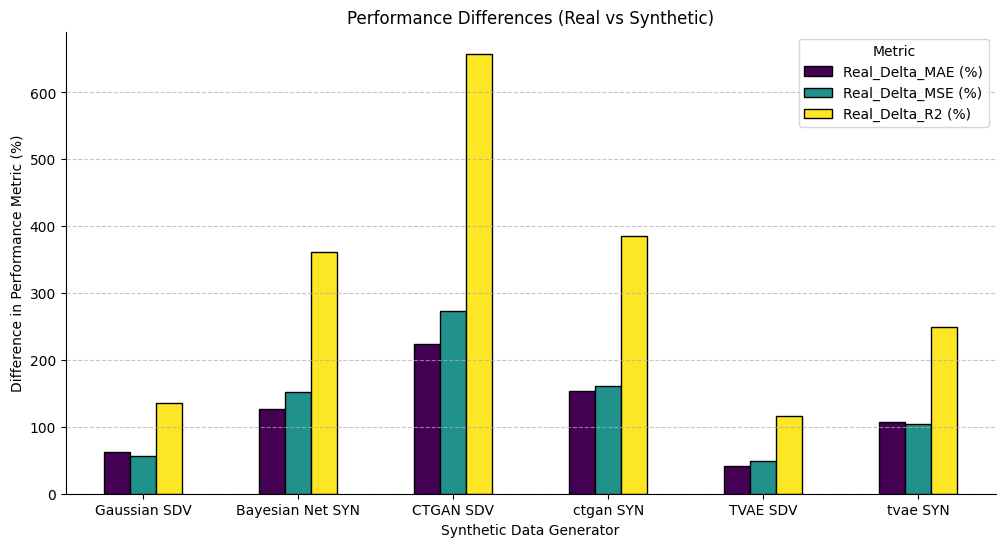

In [66]:
# Visualize differences
metrics = ["Real_Delta_MAE (%)", "Real_Delta_MSE (%)", "Real_Delta_R2 (%)"]

fig, ax = plt.subplots(figsize=(12,6))
# Plot bar chart
diff_metrics[metrics].plot(kind="bar", ax=ax, colormap="viridis", edgecolor="black")

ax.set_title("Performance Differences (Real vs Synthetic)")
ax.set_ylabel("Difference in Performance Metric (%)")
ax.set_xlabel("Synthetic Data Generator")
ax.set_xticklabels(diff_metrics.index, rotation=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend(title="Metric")
plt.show()


     MAE_avg       MSE_avg   R2_avg  Delta_TEST_MAE  Delta_TEST_MSE  \
0  58.714252  11626.832061  0.32521       13.014215      3449.53216   

   Delta_TEST_R2  MAE_Score  MSE_Score  R2_Score  
0       0.028926   0.715225   0.578158  0.902371  
                  MAE_Score  MSE_Score  R2_Score
TVAE SDV           0.578231   0.514074 -0.158989
Gaussian SDV       0.382699   0.430489 -0.362421
tvae SYN          -0.065836  -0.043759 -1.497715
Bayesian Net SYN  -0.260525  -0.515256 -2.620124
ctgan SYN         -0.530261  -0.607530 -2.848651
CTGAN SDV         -1.239893  -1.735533 -5.579309
TVAE SDV            0.311105
Gaussian SDV        0.150256
tvae SYN           -0.535770
Bayesian Net SYN   -1.131968
ctgan SYN          -1.328814
CTGAN SDV          -2.851578
Name: Overall_Score, dtype: float64
0    0.731918
Name: Overall_Score, dtype: float64


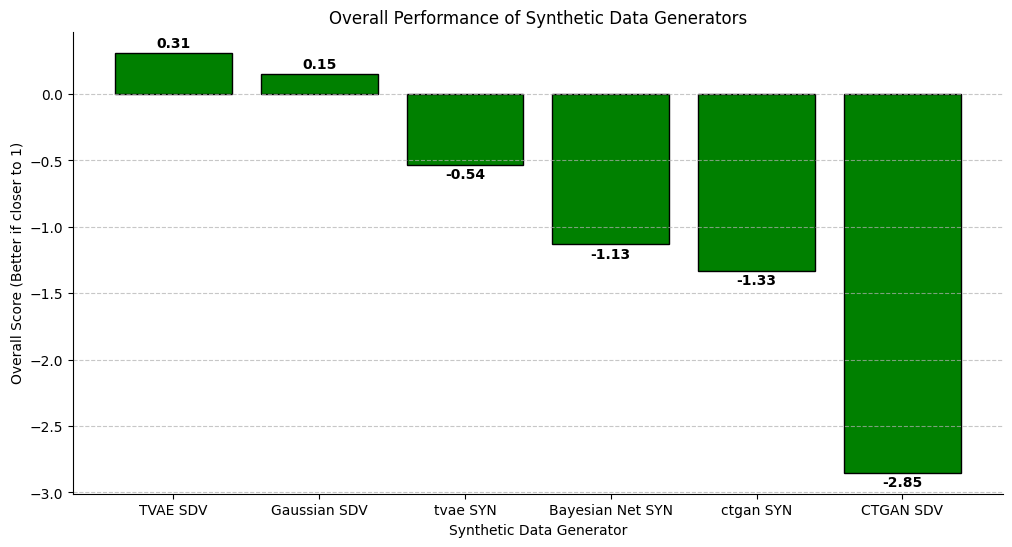

In [67]:
# Calculate the scores
diff_metrics["MAE_Score"] = 1 - (diff_metrics["Delta_MAE"] / real_metrics_df.mean()["MAE"]) 
diff_metrics["MSE_Score"] = 1 - (diff_metrics["Delta_MSE"] / real_metrics_df.mean()["MSE"])
diff_metrics["R2_Score"] = 1 - (diff_metrics["Delta_R2"] / real_metrics_df.mean()["R2"])

# TEST
diff_metrics_TEST["MAE_Score"] = 1 - (diff_metrics_TEST["Delta_TEST_MAE"] / real_metrics_df.mean()["MAE"])
diff_metrics_TEST["MSE_Score"] = 1 - (diff_metrics_TEST["Delta_TEST_MSE"] / real_metrics_df.mean()["MSE"])
diff_metrics_TEST["R2_Score"] = 1 - (diff_metrics_TEST["Delta_TEST_R2"] / real_metrics_df.mean()["R2"])
print(diff_metrics_TEST)

# Creating a overall score (since now MAE_Score, MSE_Score and R2_Score are in the same range (-inf, 1])
diff_metrics["Overall_Score"] = (diff_metrics[["MAE_Score", "MSE_Score", "R2_Score"]].mean(axis=1))
diff_metrics = diff_metrics.sort_values(by="Overall_Score", ascending=False)
print(diff_metrics[["MAE_Score", "MSE_Score", "R2_Score"]])
print(diff_metrics["Overall_Score"])

# TEST 
diff_metrics_TEST["Overall_Score"] = (diff_metrics_TEST[["MAE_Score", "MSE_Score", "R2_Score"]].mean(axis=1))
diff_metrics_TEST = diff_metrics_TEST.sort_values(by="Overall_Score")
print(diff_metrics_TEST["Overall_Score"])

# Visualize the rank
fig, ax = plt.subplots(1,1,figsize=(12,6))
bars = ax.bar(diff_metrics.index, diff_metrics["Overall_Score"], color="green", edgecolor="black")

for bar in bars:
    height = bar.get_height()
    if height >= 0:
        ax.text(bar.get_x() + bar.get_width() / 2.,
                height + 0.02,
                f"{height:.2f}",
                ha="center", va="bottom",
                fontsize=10, fontweight="bold")
    else:
        ax.text(bar.get_x() + bar.get_width() / 2.,
                height - 0.02,
                f"{height:.2f}",
                ha="center", va="top",
                fontsize=10, fontweight="bold")

ax.set_title("Overall Performance of Synthetic Data Generators")
ax.set_ylabel("Overall Score (Better if closer to 1)")
ax.set_xlabel("Synthetic Data Generator")
ax.set_xticklabels(diff_metrics.index, rotation=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()